In [5]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB, MultinomialNB, CategoricalNB, ComplementNB, BernoulliNB
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import sklearn
import sys
from sklearn.feature_selection import VarianceThreshold
from sklearn.ensemble import RandomForestClassifier
import tensorflow as tf
from tensorflow import keras  # tf.keras
from tensorflow.keras.utils import to_categorical
import time
import seaborn as sns
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix
from sklearn.model_selection import KFold
from imblearn.under_sampling import RandomUnderSampler 
from sklearn.model_selection import GridSearchCV
import joblib

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#preprocessing

In [7]:
path = "/content/drive/MyDrive/Università/MagistraleUNIPD/Structural Bioinformatics/contacts_classification/contacts_classification/features_ring"

In [8]:
path = "/content/drive/MyDrive/contacts_classification/features_ring"

In [9]:
# Combine all PDBs into a single dataframe
dfs = []
for filename in os.listdir(path):
    dfs.append(pd.read_csv(path + "/" + filename, sep='\t'))
df = pd.concat(dfs)

# Create a new class 'Missing' for unclassified contacts
df['Interaction'].fillna('Missing', inplace=True)
df

,pdb_id,s_ch,s_resi,s_ins,s_resn,s_ss8,s_rsa,s_up,s_down,s_phi,...,t_down,t_phi,t_psi,t_ss3,t_a1,t_a2,t_a3,t_a4,t_a5,Interaction
0,6g62,A,73,,I,H,0.320,15.0,15.0,-1.107,...,5.0,-2.046,0.248,H,-1.019,-0.987,-1.505,1.266,-0.912,Missing
1,6g62,A,45,,P,H,0.551,4.0,13.0,-1.041,...,20.0,-1.097,-0.718,H,-1.019,-0.987,-1.505,1.266,-0.912,HBOND
2,6g62,A,45,,P,H,0.551,4.0,13.0,-1.041,...,15.0,-1.034,-0.746,H,1.357,-1.453,1.477,0.113,-0.837,HBOND
3,6g62,A,109,,E,H,0.407,5.0,12.0,-1.121,...,5.0,-2.045,-0.021,H,0.260,0.830,3.097,-0.838,1.512,Missing
4,6g62,A,-1,,S,-,1.000,1.0,13.0,NaN,...,18.0,-1.191,-0.522,H,0.945,0.828,1.299,-0.169,0.933,Missing
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
116,6hqc,A,76,,Q,-,0.828,2.0,19.0,1.202,...,11.0,-1.330,2.847,H,1.357,-1.453,1.477,0.113,-0.837,VDW
117,6hqc,A,97,,L,-,0.012,25.0,17.0,-2.056,...,21.0,-2.598,2.385,H,1.357,-1.453,1.477,0.113,-0.837,Missing
118,6hqc,A,101,,L,E,0.000,24.0,14.0,-2.030,...,19.0,-2.173,2.344,H,-1.019,-0.987,-1.505,1.266,-0.912,Missing
119,6hqc,A,97,,L,-,0.012,25.0,17.0,-2.056,...,9.0,-1.063,2.508,H,-0.032,0.326,2.213,0.908,1.313,HBOND


In [10]:
# Remove all rows with NaN in at least one column
df.dropna(inplace=True)

# Define ground truth values
y = df['Interaction'].astype('category')
y

0        Missing
1          HBOND
2          HBOND
3        Missing
5      PIPISTACK
         ...    
116          VDW
117      Missing
118      Missing
119        HBOND
120      Missing
Name: Interaction, Length: 652574, dtype: category
Categories (7, object): ['HBOND', 'IONIC', 'Missing', 'PICATION', 'PIPISTACK', 'SSBOND', 'VDW']

In [11]:
# Define training features
X = df[['s_rsa', 's_up', 's_down', 's_phi', 's_psi', 's_a1', 's_a2', 's_a3', 's_a4', 's_a5', 
        't_rsa', 't_up', 't_down', 't_phi', 't_psi', 't_a1', 't_a2', 't_a3', 't_a4', 't_a5']]

# Calculate percentiles and tranform into categories
# X = X.rank(pct=True).round(1).astype('category') 
X

,s_rsa,s_up,s_down,s_phi,s_psi,s_a1,s_a2,s_a3,s_a4,s_a5,t_rsa,t_up,t_down,t_phi,t_psi,t_a1,t_a2,t_a3,t_a4,t_a5
0,0.320,15.0,15.0,-1.107,-0.481,-1.239,-0.547,2.131,0.393,0.816,0.006,22.0,5.0,-2.046,0.248,-1.019,-0.987,-1.505,1.266,-0.912
1,0.551,4.0,13.0,-1.041,-0.608,0.189,2.081,-1.628,0.421,-1.392,0.226,11.0,20.0,-1.097,-0.718,-1.019,-0.987,-1.505,1.266,-0.912
2,0.551,4.0,13.0,-1.041,-0.608,0.189,2.081,-1.628,0.421,-1.392,0.608,7.0,15.0,-1.034,-0.746,1.357,-1.453,1.477,0.113,-0.837
3,0.407,5.0,12.0,-1.121,-0.836,1.357,-1.453,1.477,0.113,-0.837,0.032,23.0,5.0,-2.045,-0.021,0.260,0.830,3.097,-0.838,1.512
5,0.000,20.0,16.0,-1.098,-0.769,-1.006,-0.590,1.891,-0.397,0.412,0.000,22.0,22.0,-1.545,2.148,-1.006,-0.590,1.891,-0.397,0.412
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
116,0.828,2.0,19.0,1.202,0.495,0.931,-0.179,-3.005,-0.503,-1.853,0.603,5.0,11.0,-1.330,2.847,1.357,-1.453,1.477,0.113,-0.837
117,0.012,25.0,17.0,-2.056,2.618,-1.019,-0.987,-1.505,1.266,-0.912,0.515,11.0,21.0,-2.598,2.385,1.357,-1.453,1.477,0.113,-0.837
118,0.000,24.0,14.0,-2.030,2.320,-1.019,-0.987,-1.505,1.266,-0.912,0.341,8.0,19.0,-2.173,2.344,-1.019,-0.987,-1.505,1.266,-0.912
119,0.012,25.0,17.0,-2.056,2.618,-1.019,-0.987,-1.505,1.266,-0.912,0.042,19.0,9.0,-1.063,2.508,-0.032,0.326,2.213,0.908,1.313


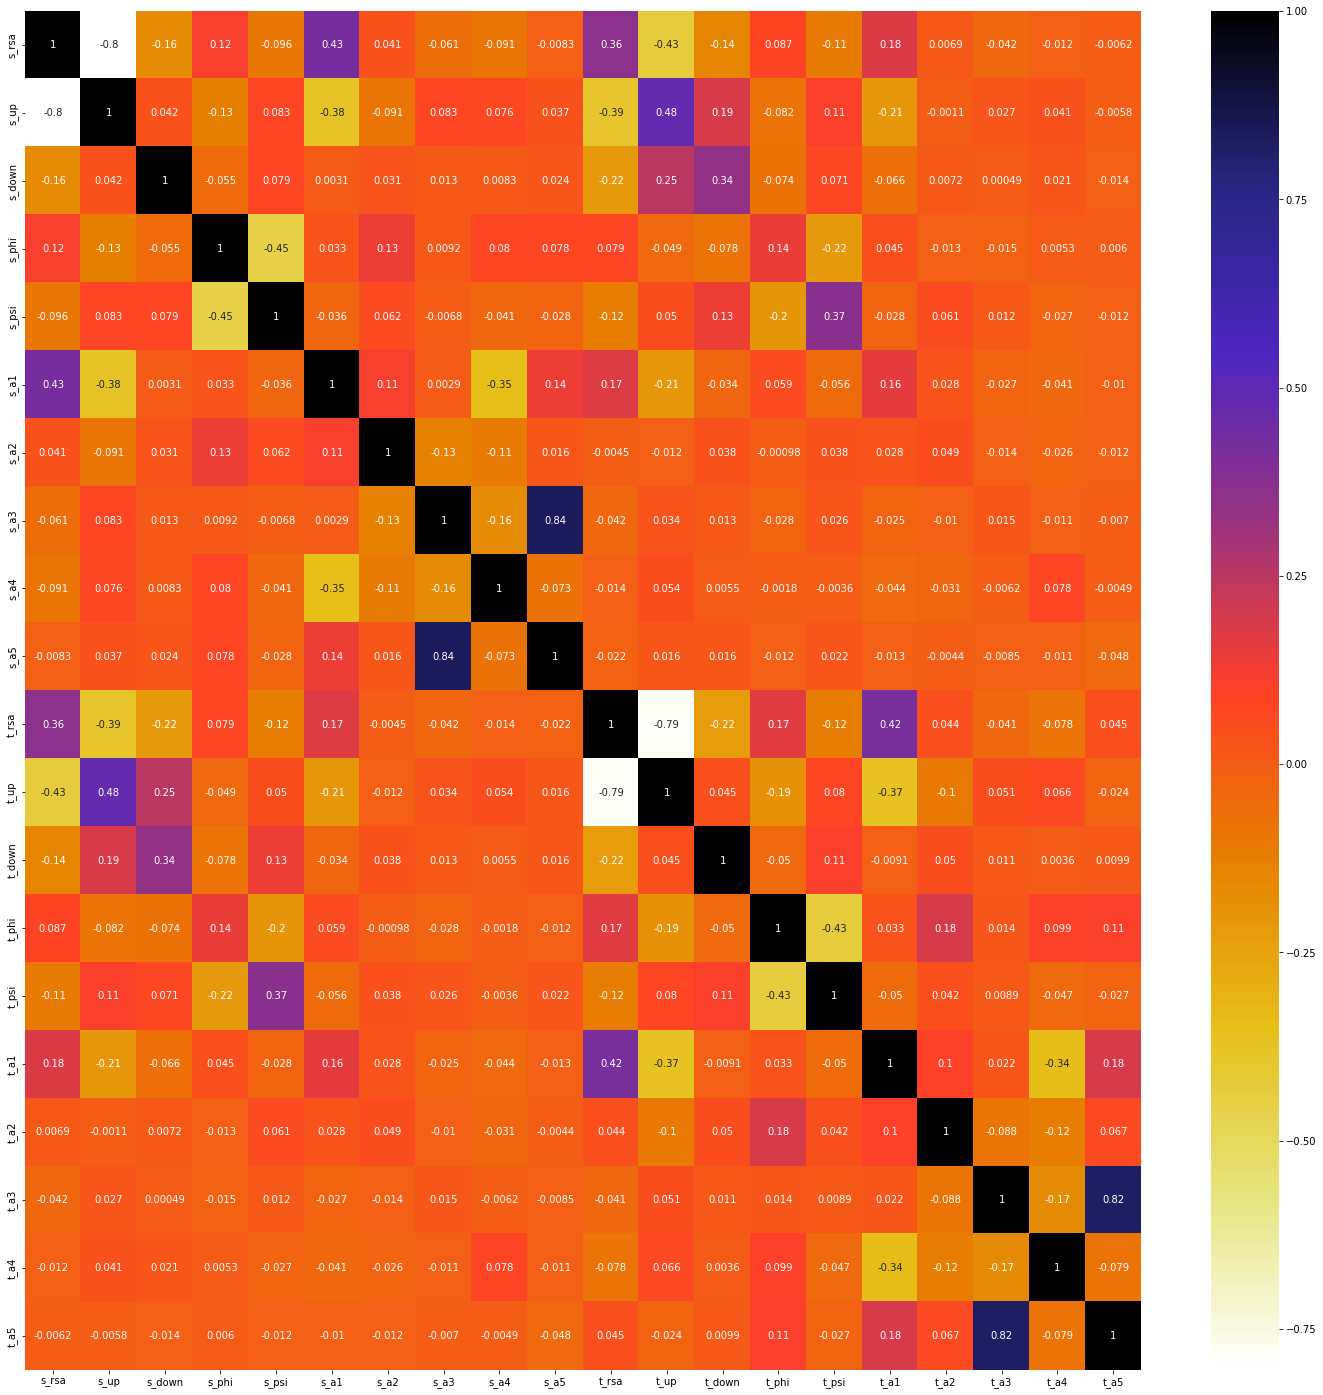

In [12]:
#obtain the correlation matrix
plt.figure(figsize=(25,25))
cor = X.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.CMRmap_r)
plt.show()

In [13]:
# with the following function we can select highly correlated features
def correlation(dataset, threshold):
    col_corr = set()  # Set of all the names of correlated columns
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold: #we are interested absolute value of correlation
                colname = corr_matrix.columns[i]  # getting the name of column
                col_corr.add(colname)
    return col_corr

In [14]:
corr_features = correlation(X, 0.8)
print(len(set(corr_features)))
print(corr_features) #name of the features with absolute(correlation) higher than threshold

3
{'t_a5', 's_up', 's_a5'}


In [15]:
X = X.drop(corr_features, axis=1)
X

,s_rsa,s_down,s_phi,s_psi,s_a1,s_a2,s_a3,s_a4,t_rsa,t_up,t_down,t_phi,t_psi,t_a1,t_a2,t_a3,t_a4
0,0.320,15.0,-1.107,-0.481,-1.239,-0.547,2.131,0.393,0.006,22.0,5.0,-2.046,0.248,-1.019,-0.987,-1.505,1.266
1,0.551,13.0,-1.041,-0.608,0.189,2.081,-1.628,0.421,0.226,11.0,20.0,-1.097,-0.718,-1.019,-0.987,-1.505,1.266
2,0.551,13.0,-1.041,-0.608,0.189,2.081,-1.628,0.421,0.608,7.0,15.0,-1.034,-0.746,1.357,-1.453,1.477,0.113
3,0.407,12.0,-1.121,-0.836,1.357,-1.453,1.477,0.113,0.032,23.0,5.0,-2.045,-0.021,0.260,0.830,3.097,-0.838
5,0.000,16.0,-1.098,-0.769,-1.006,-0.590,1.891,-0.397,0.000,22.0,22.0,-1.545,2.148,-1.006,-0.590,1.891,-0.397
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
116,0.828,19.0,1.202,0.495,0.931,-0.179,-3.005,-0.503,0.603,5.0,11.0,-1.330,2.847,1.357,-1.453,1.477,0.113
117,0.012,17.0,-2.056,2.618,-1.019,-0.987,-1.505,1.266,0.515,11.0,21.0,-2.598,2.385,1.357,-1.453,1.477,0.113
118,0.000,14.0,-2.030,2.320,-1.019,-0.987,-1.505,1.266,0.341,8.0,19.0,-2.173,2.344,-1.019,-0.987,-1.505,1.266
119,0.012,17.0,-2.056,2.618,-1.019,-0.987,-1.505,1.266,0.042,19.0,9.0,-1.063,2.508,-0.032,0.326,2.213,0.908


In [16]:
def plot_loss(history):
  plt.figure(figsize=(10,6))
  plt.plot(history.epoch, history.history['loss'])
  plt.plot(history.epoch, history.history['val_loss'])
  plt.title('loss')

def plot_accuracy(history):
  plt.figure(figsize=(10,6))
  plt.plot(history.epoch, history.history['accuracy'])
  plt.plot(history.epoch, history.history['val_accuracy'])
  plt.title('accuracy')


# Model: Binary NN & Rand Forest

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                180       
                                                                 
 dense_1 (Dense)             (None, 5)                 55        
                                                                 
 dense_2 (Dense)             (None, 1)                 6         
                                                                 
Total params: 241
Trainable params: 241
Non-trainable params: 0
_________________________________________________________________


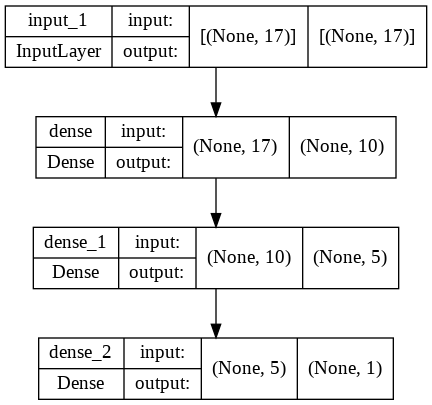

In [ ]:
n = len(X.columns)
model = keras.models.Sequential([
    tf.keras.Input(shape=(n,)),
    keras.layers.Dense(10, activation="relu"),
    keras.layers.Dense(5, activation="relu"),
    keras.layers.Dense(1, activation="sigmoid")
])
model.summary()
keras.utils.plot_model(model, "Bio-NN.png", show_shapes=True)

In [17]:
model.compile(loss="binary_crossentropy",
              optimizer=keras.optimizers.Adam(learning_rate=1e-4),
              metrics=["accuracy"])

NameError: ignored

In [18]:
lst = ['HBOND', 'IONIC', 'Missing', 'PICATION', 'PIPISTACK', 'SSBOND', 'VDW']

In [19]:
def one_hot_encode(string, lst, y):
  y_copy = y.copy()
  for i in range(len(lst)):
      if lst[i] == string:
         y_copy.replace({lst[i]:1}, inplace=True)
      else:
         y_copy.replace({lst[i]:0}, inplace=True)
  return y_copy

## VDW classification

In [37]:
y_vdw = one_hot_encode("VDW",lst,y)


In [38]:
# Split the dataset to define training and testing examples
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y_vdw, test_size=0.1, random_state=42,shuffle=True)

k = 10
kf = KFold(n_splits=k, random_state = None)
 
F1_MARK = []

 
for train_index , valid_index in kf.split(X_train_val):
    X_train , X_valid = X_train_val.iloc[train_index,:],X_train_val.iloc[valid_index,:]
    y_train , y_valid = y_train_val.iloc[train_index] , y_train_val.iloc[valid_index]
     
    history = model.fit(X_train, y_train, epochs=5,
                    validation_data=(X_valid, y_valid))
    pred_values = model.predict(X_test)
    pred_values = np.round(pred_values)
     
    acc = f1_score(y_test, pred_values)
    F1_MARK.append(acc)

    scores = model.evaluate(X_test, y_test, verbose=2)
    print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

avg_f1_score = sum(F1_MARK)/k
print("avg_f1_score is: ", avg_f1_score)

NameError: ignored

In [39]:
# Split the dataset to define training and testing examples
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y_vdw, test_size=0.1, random_state=42,shuffle=True)
k = 10
kf = KFold(n_splits=k, random_state = None)
 
F1_MARK = []
AC_MARK = []
scores_act= 0.0

for train_index , valid_index in kf.split(X_train_val):
    X_train , X_valid = X_train_val.iloc[train_index,:],X_train_val.iloc[valid_index,:]
    y_train , y_valid = y_train_val.iloc[train_index] , y_train_val.iloc[valid_index]
     
    rf_grid_params = {
    'n_estimators': (5, 10, 20),
    'criterion': ['entropy'],
    'max_depth': (None, 3, 5, 10),
    }
    rf_clf = RandomForestClassifier(random_state= 42)
    rf_v1 = GridSearchCV(rf_clf, rf_grid_params, n_jobs= -1, cv = 5)
    rf_v1.fit(X_train, y_train)
    y_train_pred = rf_v1.predict(X_train)
    y_val_pred = rf_v1.predict(X_valid)
    scores = rf_v1.score(X_test, y_test)
    scores_v = rf_v1.score(X_valid, y_valid)
    print(f"Random Forest - Accuracy \tTest:{scores*100:.4f}\tVal:{scores_v*100:.4f}")
    f1 = f1_score(y_valid, y_val_pred,average = 'macro')
    F1_MARK.append(f1)
    AC_MARK.append(scores_v)

    if scores_act < scores_v:
      rf_vdw = rf_v1
      scores_act = scores_v
     
avg_f1_score = sum(F1_MARK)/k
avg_ac_score = sum(AC_MARK)/k
print("\navg_f1_score is: ", avg_f1_score)
print("avg_ac_score is: ", avg_ac_score)


/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:705: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


Random Forest - Accuracy 	Test:79.0861	Val:78.5500


/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:705: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


Random Forest - Accuracy 	Test:79.0861	Val:78.7918


/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:705: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


Random Forest - Accuracy 	Test:79.0846	Val:78.7867


/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:705: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


Random Forest - Accuracy 	Test:79.0892	Val:78.6471
Random Forest - Accuracy 	Test:79.0800	Val:78.9416
Random Forest - Accuracy 	Test:79.0830	Val:78.8786
Random Forest - Accuracy 	Test:79.0815	Val:78.9907
Random Forest - Accuracy 	Test:79.0953	Val:78.8851
Random Forest - Accuracy 	Test:79.0754	Val:78.8732
Random Forest - Accuracy 	Test:79.0646	Val:79.0043

avg_f1_score is:  0.44257850906646395
avg_ac_score is:  0.7883490389085976


## HBOND classification

In [ ]:
y_hb = one_hot_encode("HBOND",lst,y)

Epoch 1/5
16519/16519 [==============================] - 32s 2ms/step - loss: 0.6929 - accuracy: 0.6385 - val_loss: 0.6187 - val_accuracy: 0.6745
Epoch 2/5
16519/16519 [==============================] - 31s 2ms/step - loss: 0.6209 - accuracy: 0.6700 - val_loss: 0.6166 - val_accuracy: 0.6734
Epoch 3/5
16519/16519 [==============================] - 32s 2ms/step - loss: 0.6193 - accuracy: 0.6720 - val_loss: 0.6133 - val_accuracy: 0.6798
Epoch 4/5
16519/16519 [==============================] - 31s 2ms/step - loss: 0.6149 - accuracy: 0.6756 - val_loss: 0.6112 - val_accuracy: 0.6727
Epoch 5/5
16519/16519 [==============================] - 31s 2ms/step - loss: 0.6120 - accuracy: 0.6775 - val_loss: 0.6076 - val_accuracy: 0.6794
2040/2040 - 2s - loss: 0.6100 - accuracy: 0.6785 - 2s/epoch - 1ms/step
accuracy: 67.85%
Epoch 1/5
16519/16519 [==============================] - 32s 2ms/step - loss: 0.6100 - accuracy: 0.6788 - val_loss: 0.6122 - val_accuracy: 0.6771
Epoch 2/5
16519/16519 [=============

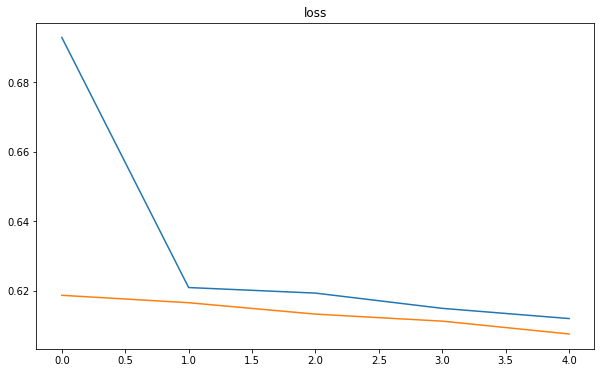

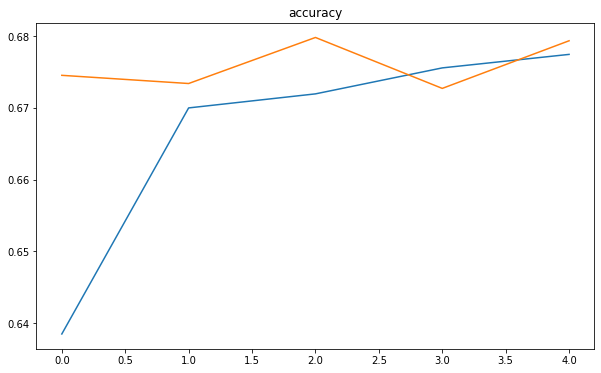

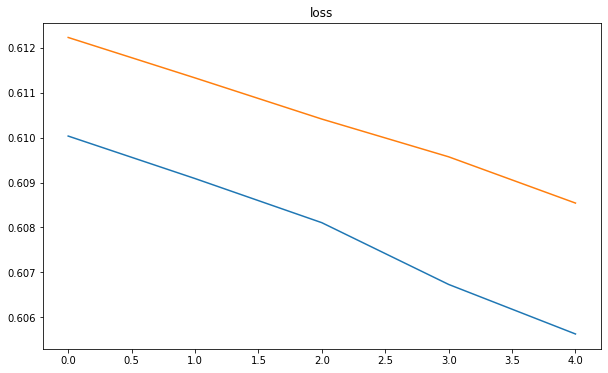

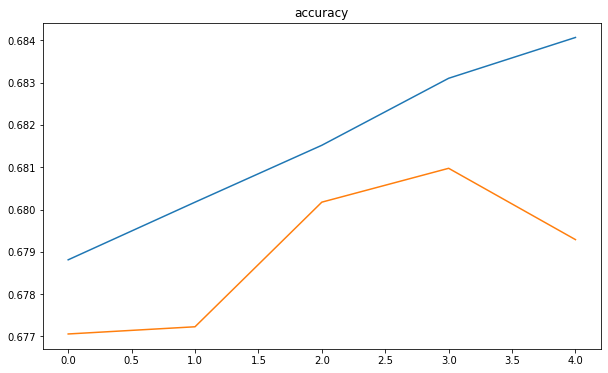

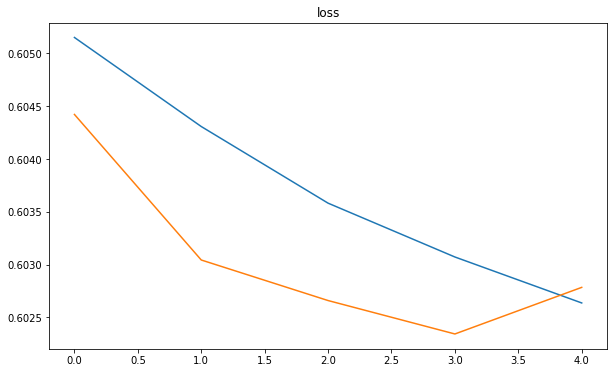

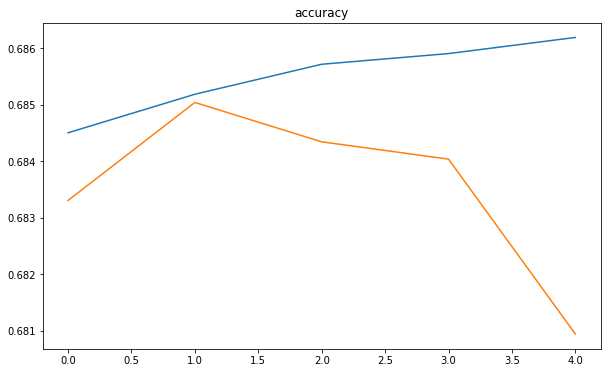

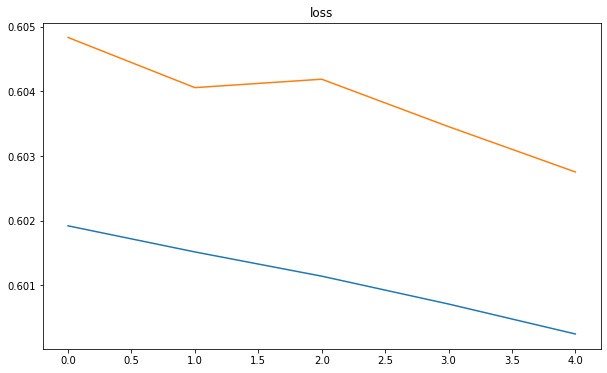

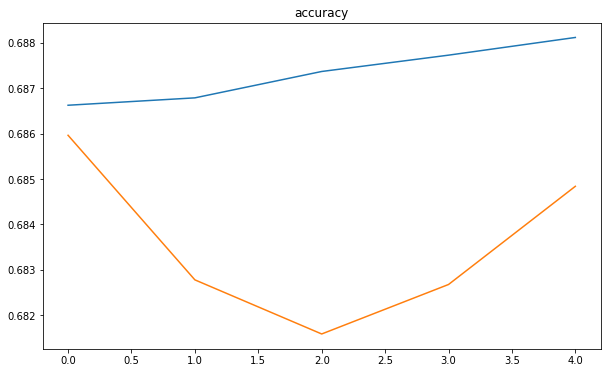

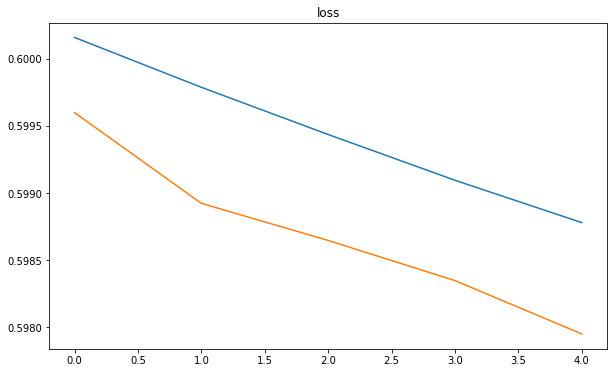

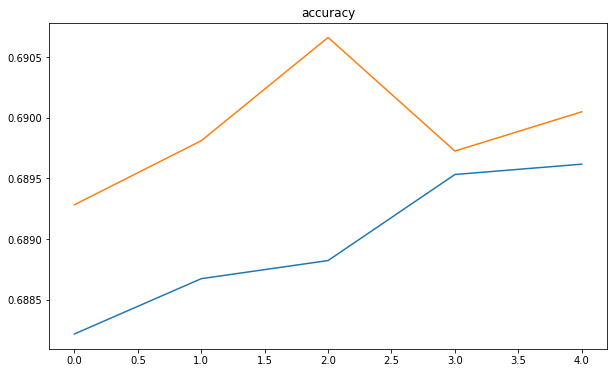

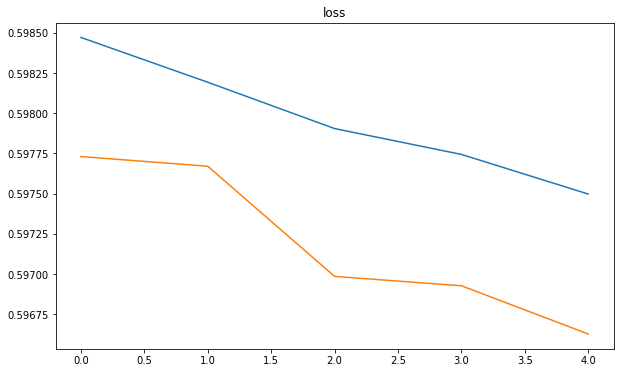

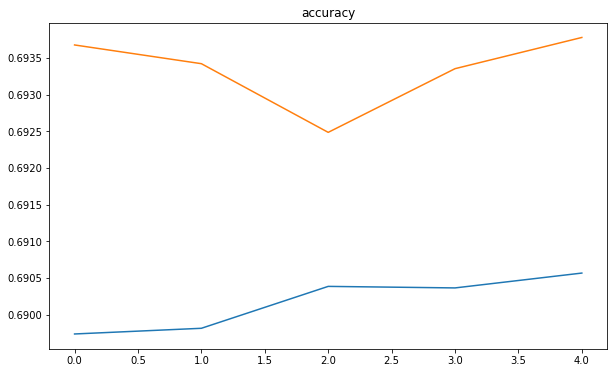

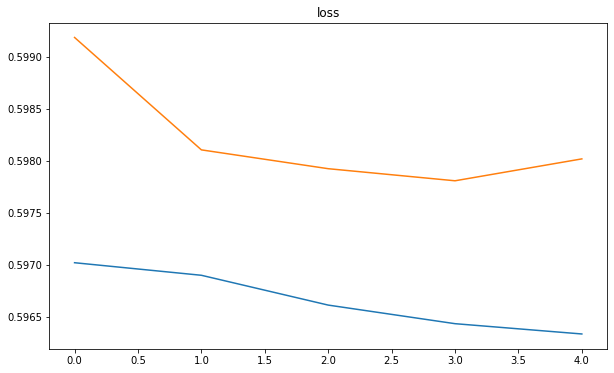

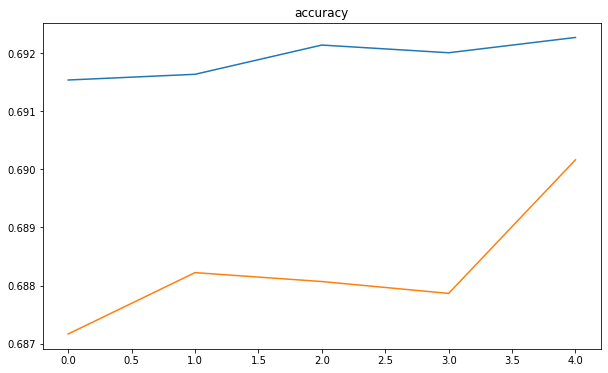

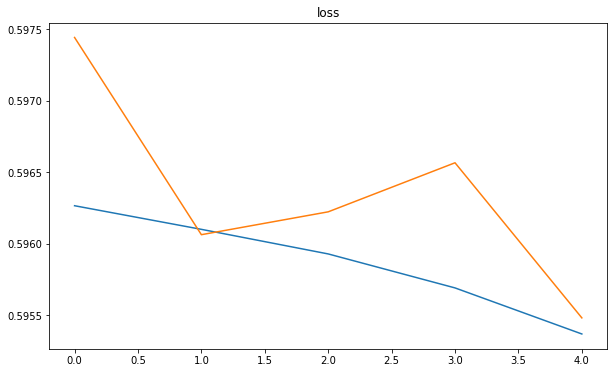

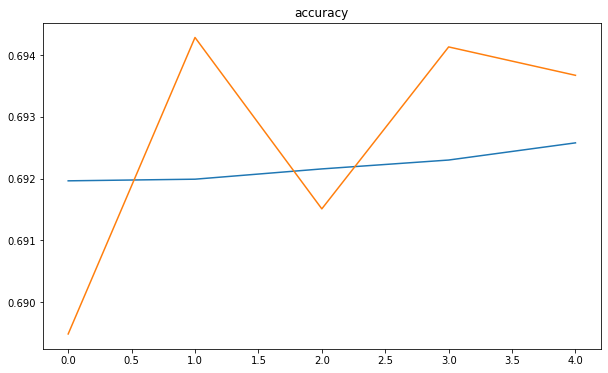

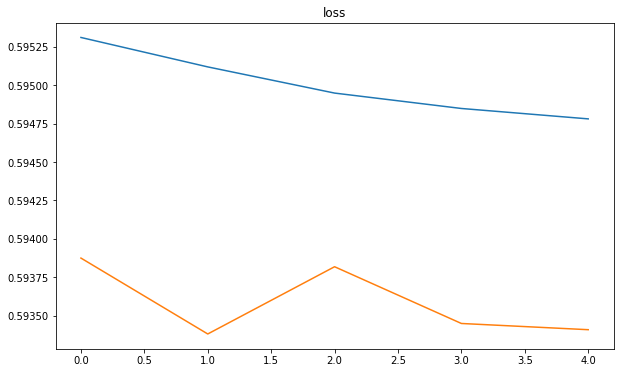

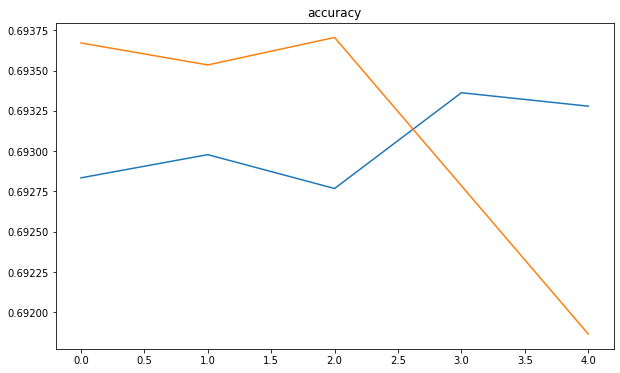

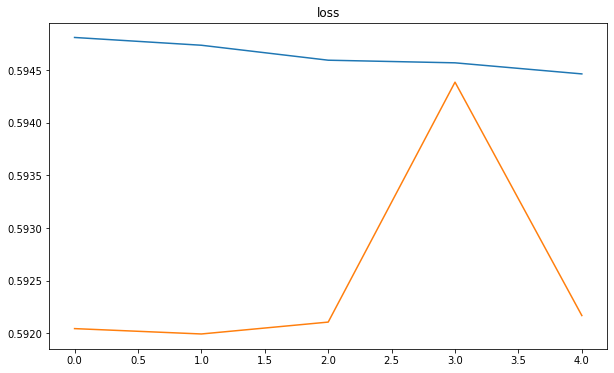

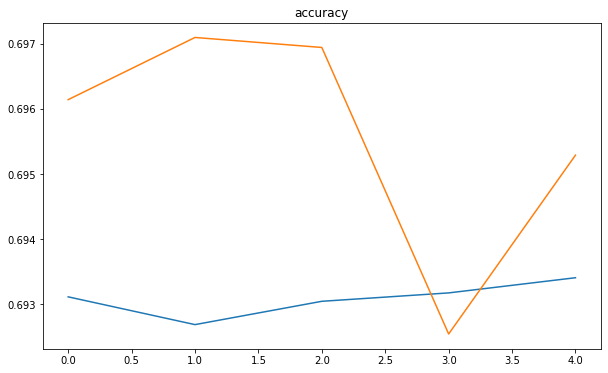

In [ ]:
# Split the dataset to define training and testing examples
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y_hb, test_size=0.1, random_state=42,shuffle=True)

k = 10
kf = KFold(n_splits=k, random_state = None)
 
F1_MARK = []
 
for train_index , valid_index in kf.split(X_train_val):
    X_train , X_valid = X_train_val.iloc[train_index,:],X_train_val.iloc[valid_index,:]
    y_train , y_valid = y_train_val.iloc[train_index] , y_train_val.iloc[valid_index]
     
    history = model.fit(X_train, y_train, epochs=5,
                    validation_data=(X_valid, y_valid))
    pred_values = model.predict(X_test)
    pred_values = np.round(pred_values)
    pred_values = pred_values.astype(int)

     
    acc = f1_score(y_test, pred_values)
    F1_MARK.append(acc)

    scores = model.evaluate(X_test, y_test, verbose=2)
    print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
     
avg_f1_score = sum(F1_MARK)/k
print("avg_f1_score is: ", avg_f1_score)

In [ ]:
# Split the dataset to define training and testing examples
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y_hb, test_size=0.1, random_state=42,shuffle=True)
k = 10
kf = KFold(n_splits=k, random_state = None)
 
F1_MARK = []
AC_MARK = []
scores_act= 0.0
 
for train_index , valid_index in kf.split(X_train_val):
    X_train , X_valid = X_train_val.iloc[train_index,:],X_train_val.iloc[valid_index,:]
    y_train , y_valid = y_train_val.iloc[train_index] , y_train_val.iloc[valid_index]
     
    rf_grid_params = {
    'n_estimators': (5, 10, 20),
    'criterion': ['entropy'],
    'max_depth': (None, 3, 5, 10),
    }
    rf_clf = RandomForestClassifier(random_state= 42)
    rf_v1 = GridSearchCV(rf_clf, rf_grid_params, n_jobs= -1, cv = 5)
    rf_v1.fit(X_train, y_train)
    y_train_pred = rf_v1.predict(X_train)
    y_val_pred = rf_v1.predict(X_valid)
    scores = rf_v1.score(X_test, y_test)
    scores_v = rf_v1.score(X_valid, y_valid)
    print(f"Random Forest - Accuracy \tTest:{scores*100:.4f}\tVal:{scores_v*100:.4f}")
    f1 = f1_score(y_valid, y_val_pred,average = 'macro')
    F1_MARK.append(f1)
    AC_MARK.append(scores_v)

    if scores_act < scores_v:
        rf_hb = rf_v1
        scores_act = scores_v
     
avg_f1_score = sum(F1_MARK)/k
avg_ac_score = sum(AC_MARK)/k
print("\navg_f1_score is: ", avg_f1_score)
print("avg_ac_score is: ", avg_ac_score)

## IONIC classification

In [20]:
y_io = one_hot_encode("IONIC",lst,y)

In [21]:
rus = RandomUnderSampler(random_state=42)
X_io, y_io = rus.fit_resample(X, y_io)

In [22]:
# Split the dataset to define training and testing examples
X_train_val, X_test, y_train_val, y_test = train_test_split(X_io, y_io, test_size=0.1, random_state=42,shuffle=True)

k = 10
kf = KFold(n_splits=k, random_state = None)
 
F1_MARK = []
 
for train_index , valid_index in kf.split(X_train_val):
    X_train , X_valid = X_train_val.iloc[train_index,:],X_train_val.iloc[valid_index,:]
    y_train , y_valid = y_train_val.iloc[train_index] , y_train_val.iloc[valid_index]
     
    history = model.fit(X_train, y_train, epochs=5,
                    validation_data=(X_valid, y_valid))
    pred_values = model.predict(X_test)
    pred_values = np.round(pred_values)
    pred_values = pred_values.astype(int)
    acc = f1_score(y_test, pred_values)
    F1_MARK.append(acc)

    scores = model.evaluate(X_test, y_test, verbose=2)
    print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
     
avg_f1_score = sum(F1_MARK)/k
print("avg_f1_score is: ", avg_f1_score)

NameError: ignored

In [23]:
# Split the dataset to define training and testing examples
X_train_val, X_test, y_train_val, y_test = train_test_split(X_io, y_io, test_size=0.1, random_state=42,shuffle=True)
k = 10
kf = KFold(n_splits=k, random_state = None)
 
F1_MARK = []
AC_MARK = []
scores_act= 0.0
 
for train_index , valid_index in kf.split(X_train_val):
    X_train , X_valid = X_train_val.iloc[train_index,:],X_train_val.iloc[valid_index,:]
    y_train , y_valid = y_train_val.iloc[train_index] , y_train_val.iloc[valid_index]
     
    rf_grid_params = {
    'n_estimators': (5, 10, 20),
    'criterion': ['entropy'],
    'max_depth': (None, 3, 5, 10),
    }
    rf_clf = RandomForestClassifier(random_state= 42)
    rf_v1 = GridSearchCV(rf_clf, rf_grid_params, n_jobs= -1, cv = 5)
    rf_v1.fit(X_train, y_train)
    y_train_pred = rf_v1.predict(X_train)
    y_val_pred = rf_v1.predict(X_valid)
    scores = rf_v1.score(X_test, y_test)
    scores_v = rf_v1.score(X_valid, y_valid)
    print(f"Random Forest - Accuracy \tTest:{scores*100:.4f}\tVal:{scores_v*100:.4f}")
    f1 = f1_score(y_valid, y_val_pred,average = 'macro')
    F1_MARK.append(f1)
    AC_MARK.append(scores_v)

    if scores_act < scores_v:
      rf_io = rf_v1
      cores_act = scores_v
     
avg_f1_score = sum(F1_MARK)/k
avg_ac_score = sum(AC_MARK)/k
print("\navg_f1_score is: ", avg_f1_score)
print("avg_ac_score is: ", avg_ac_score)

Random Forest - Accuracy 	Test:96.6896	Val:97.2241
Random Forest - Accuracy 	Test:96.8770	Val:97.2241
Random Forest - Accuracy 	Test:96.9394	Val:96.9466
Random Forest - Accuracy 	Test:97.0643	Val:97.2222
Random Forest - Accuracy 	Test:96.6896	Val:97.0139
Random Forest - Accuracy 	Test:96.8145	Val:97.2222
Random Forest - Accuracy 	Test:96.8770	Val:97.2222
Random Forest - Accuracy 	Test:96.7520	Val:97.0833
Random Forest - Accuracy 	Test:97.0643	Val:97.7083
Random Forest - Accuracy 	Test:96.8770	Val:96.5278

avg_f1_score is:  0.9713407473055545
avg_ac_score is:  0.9713948646773074


## PIPSTACK classification

In [25]:
y_pip = one_hot_encode("PIPISTACK", lst,y)

In [26]:
rus = RandomUnderSampler(random_state=42)
X_pip, y_pip = rus.fit_resample(X, y_pip)

In [ ]:
# Split the dataset to define training and testing examples
X_train_val, X_test, y_train_val, y_test = train_test_split(X_pip, y_pip, test_size=0.1, random_state=42,shuffle=True)

k = 10
kf = KFold(n_splits=k, random_state = None)
 
F1_MARK = []

 
for train_index , valid_index in kf.split(X_train_val):
    X_train , X_valid = X_train_val.iloc[train_index,:],X_train_val.iloc[valid_index,:]
    y_train , y_valid = y_train_val.iloc[train_index] , y_train_val.iloc[valid_index]
     
    history = model.fit(X_train, y_train, epochs=5,
                    validation_data=(X_valid, y_valid))
    pred_values = model.predict(X_test)
    pred_values = np.round(pred_values)
    pred_values = pred_values.astype(int)
    acc = f1_score(y_test, pred_values)
    F1_MARK.append(acc)


    scores = model.evaluate(X_test, y_test, verbose=2)
    print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
     
avg_f1_score = sum(F1_MARK)/k
print("avg_f1_score is: ", avg_f1_score)

Epoch 1/5
467/467 [==============================] - 2s 3ms/step - loss: 1.0831 - accuracy: 0.5134 - val_loss: 0.7026 - val_accuracy: 0.5849
Epoch 2/5
467/467 [==============================] - 1s 2ms/step - loss: 0.6403 - accuracy: 0.6516 - val_loss: 0.6039 - val_accuracy: 0.6916
Epoch 3/5
467/467 [==============================] - 1s 2ms/step - loss: 0.5866 - accuracy: 0.7085 - val_loss: 0.5560 - val_accuracy: 0.7313
Epoch 4/5
467/467 [==============================] - 1s 2ms/step - loss: 0.5260 - accuracy: 0.7625 - val_loss: 0.5026 - val_accuracy: 0.7795
Epoch 5/5
467/467 [==============================] - 1s 2ms/step - loss: 0.4743 - accuracy: 0.7952 - val_loss: 0.4543 - val_accuracy: 0.8012
58/58 - 0s - loss: 0.4544 - accuracy: 0.7950 - 79ms/epoch - 1ms/step
accuracy: 79.50%
Epoch 1/5
467/467 [==============================] - 1s 2ms/step - loss: 0.4194 - accuracy: 0.8155 - val_loss: 0.3719 - val_accuracy: 0.8434
Epoch 2/5
467/467 [==============================] - 1s 2ms/step - l

In [27]:
# Split the dataset to define training and testing examples
X_train_val, X_test, y_train_val, y_test = train_test_split(X_pip, y_pip, test_size=0.1, random_state=42,shuffle=True)
k = 10
kf = KFold(n_splits=k, random_state = None)
 
F1_MARK = []
AC_MARK = []
scores_act= 0.0
 
for train_index , valid_index in kf.split(X_train_val):
    X_train , X_valid = X_train_val.iloc[train_index,:],X_train_val.iloc[valid_index,:]
    y_train , y_valid = y_train_val.iloc[train_index] , y_train_val.iloc[valid_index]
     
    rf_grid_params = {
    'n_estimators': (5, 10, 20),
    'criterion': ['entropy'],
    'max_depth': (None, 3, 5, 10),
    }
    rf_clf = RandomForestClassifier(random_state= 42)
    rf_v1 = GridSearchCV(rf_clf, rf_grid_params, n_jobs= -1, cv = 5)
    rf_v1.fit(X_train, y_train)
    y_train_pred = rf_v1.predict(X_train)
    y_val_pred = rf_v1.predict(X_valid)
    scores = rf_v1.score(X_test, y_test)
    scores_v = rf_v1.score(X_valid, y_valid)
    print(f"Random Forest - Accuracy \tTest:{scores*100:.4f}\tVal:{scores_v*100:.4f}")
    f1 = f1_score(y_valid, y_val_pred,average = 'macro')
    F1_MARK.append(f1)
    AC_MARK.append(scores_v)

    if scores_act < scores_v:
        rf_pip = rf_v1
        scores_act = scores_v
     
avg_f1_score = sum(F1_MARK)/k
avg_ac_score = sum(AC_MARK)/k
print("\navg_f1_score is: ", avg_f1_score)
print("avg_ac_score is: ", avg_ac_score)

Random Forest - Accuracy 	Test:98.8069	Val:98.6145
Random Forest - Accuracy 	Test:98.8069	Val:99.0361
Random Forest - Accuracy 	Test:98.6985	Val:98.6739
Random Forest - Accuracy 	Test:98.8069	Val:98.6136
Random Forest - Accuracy 	Test:98.8069	Val:98.9753
Random Forest - Accuracy 	Test:98.8069	Val:98.5533
Random Forest - Accuracy 	Test:98.8069	Val:98.5533
Random Forest - Accuracy 	Test:98.8069	Val:98.7342
Random Forest - Accuracy 	Test:98.8069	Val:98.5533
Random Forest - Accuracy 	Test:98.8069	Val:98.5533

avg_f1_score is:  0.9868513350212005
avg_ac_score is:  0.9868609701010188


## SSBOND classification

In [33]:
y_ss = one_hot_encode("SSBOND",lst,y)

In [34]:
rus = RandomUnderSampler(random_state=42)
X_ss, y_ss = rus.fit_resample(X, y_ss)

In [ ]:
# Split the dataset to define training and testing examples
X_train_val, X_test, y_train_val, y_test = train_test_split(X_ss, y_ss, test_size=0.1, random_state=42,shuffle=True)

k = 10
kf = KFold(n_splits=k, random_state = None)
 
F1_MARK = []
 
for train_index , valid_index in kf.split(X_train_val):
    X_train , X_valid = X_train_val.iloc[train_index,:],X_train_val.iloc[valid_index,:]
    y_train , y_valid = y_train_val.iloc[train_index] , y_train_val.iloc[valid_index]
     
    history = model.fit(X_train, y_train, epochs=5,
                    validation_data=(X_valid, y_valid))
    pred_values = model.predict(X_test)
    pred_values = np.round(pred_values)
    pred_values = pred_values.astype(int)
    acc = f1_score(y_test, pred_values)
    F1_MARK.append(acc)

    scores = model.evaluate(X_test, y_test, verbose=2)
    print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
     
avg_f1_score = sum(F1_MARK)/k
print("avg_f1_score is: ", avg_f1_score)

Epoch 1/5
40/40 [==============================] - 0s 5ms/step - loss: 0.1679 - accuracy: 0.9628 - val_loss: 0.1392 - val_accuracy: 0.9716
Epoch 2/5
40/40 [==============================] - 0s 3ms/step - loss: 0.1557 - accuracy: 0.9628 - val_loss: 0.1313 - val_accuracy: 0.9716
Epoch 3/5
40/40 [==============================] - 0s 3ms/step - loss: 0.1452 - accuracy: 0.9644 - val_loss: 0.1248 - val_accuracy: 0.9787
Epoch 4/5
40/40 [==============================] - 0s 3ms/step - loss: 0.1365 - accuracy: 0.9668 - val_loss: 0.1201 - val_accuracy: 0.9787
Epoch 5/5
40/40 [==============================] - 0s 3ms/step - loss: 0.1298 - accuracy: 0.9668 - val_loss: 0.1164 - val_accuracy: 0.9787
5/5 - 0s - loss: 0.1458 - accuracy: 0.9618 - 25ms/epoch - 5ms/step
accuracy: 96.18%
Epoch 1/5
40/40 [==============================] - 0s 4ms/step - loss: 0.1267 - accuracy: 0.9660 - val_loss: 0.0959 - val_accuracy: 0.9858
Epoch 2/5
40/40 [==============================] - 0s 3ms/step - loss: 0.1221 - ac

In [35]:
# Split the dataset to define training and testing examples
X_train_val, X_test, y_train_val, y_test = train_test_split(X_ss, y_ss, test_size=0.1, random_state=42,shuffle=True)
k = 10
kf = KFold(n_splits=k, random_state = None)
 
F1_MARK = []
AC_MARK = []
scores_act= 0.0
 
for train_index , valid_index in kf.split(X_train_val):
    X_train , X_valid = X_train_val.iloc[train_index,:],X_train_val.iloc[valid_index,:]
    y_train , y_valid = y_train_val.iloc[train_index] , y_train_val.iloc[valid_index]
     
    rf_grid_params = {
    'n_estimators': (5, 10, 20),
    'criterion': ['entropy'],
    'max_depth': (None, 3, 5, 10),
    }
    rf_clf = RandomForestClassifier(random_state= 42)
    rf_v1 = GridSearchCV(rf_clf, rf_grid_params, n_jobs= -1, cv = 5)
    rf_v1.fit(X_train, y_train)
    y_train_pred = rf_v1.predict(X_train)
    y_val_pred = rf_v1.predict(X_valid)
    scores = rf_v1.score(X_test, y_test)
    scores_v = rf_v1.score(X_valid, y_valid)
    print(f"Random Forest - Accuracy \tTest:{scores*100:.4f}\tVal:{scores_v*100:.4f}")
    f1 = f1_score(y_valid, y_val_pred,average = 'macro')
    F1_MARK.append(f1)
    AC_MARK.append(scores_v)

    if scores_act < scores_v:
        rf_ss = rf_v1
        scores_act = scores_v
     
avg_f1_score = sum(F1_MARK)/k
avg_ac_score = sum(AC_MARK)/k
print("\navg_f1_score is: ", avg_f1_score)
print("avg_ac_score is: ", avg_ac_score)

Random Forest - Accuracy 	Test:99.3631	Val:100.0000
Random Forest - Accuracy 	Test:99.3631	Val:100.0000
Random Forest - Accuracy 	Test:99.3631	Val:100.0000
Random Forest - Accuracy 	Test:99.3631	Val:100.0000
Random Forest - Accuracy 	Test:99.3631	Val:100.0000
Random Forest - Accuracy 	Test:99.3631	Val:100.0000
Random Forest - Accuracy 	Test:99.3631	Val:100.0000
Random Forest - Accuracy 	Test:99.3631	Val:100.0000
Random Forest - Accuracy 	Test:99.3631	Val:100.0000
Random Forest - Accuracy 	Test:99.3631	Val:100.0000

avg_f1_score is:  1.0
avg_ac_score is:  1.0


## PICATION classification

In [29]:
y_pic = one_hot_encode("PICATION",lst,y)

In [30]:
rus = RandomUnderSampler(random_state=42)
X_pic, y_pic = rus.fit_resample(X, y_pic)

In [ ]:
# Split the dataset to define training and testing examples
X_train_val, X_test, y_train_val, y_test = train_test_split(X_pic, y_pic, test_size=0.1, random_state=42,shuffle=True)

k = 10
kf = KFold(n_splits=k, random_state = None)
 
F1_MARK = []
 
for train_index , valid_index in kf.split(X_train_val):
    X_train , X_valid = X_train_val.iloc[train_index,:],X_train_val.iloc[valid_index,:]
    y_train , y_valid = y_train_val.iloc[train_index] , y_train_val.iloc[valid_index]
     
    history = model.fit(X_train, y_train, epochs=5,
                    validation_data=(X_valid, y_valid))
    pred_values = model.predict(X_test)
    pred_values = np.round(pred_values)
    pred_values = pred_values.astype(int)
    acc = f1_score(y_test, pred_values)
    F1_MARK.append(acc)

    scores = model.evaluate(X_test, y_test, verbose=2)
    print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
     
avg_f1_score = sum(F1_MARK)/k
print("avg_f1_score is: ", avg_f1_score)

Epoch 1/5
28/28 [==============================] - 0s 6ms/step - loss: 4.8565 - accuracy: 0.4887 - val_loss: 1.9436 - val_accuracy: 0.6869
Epoch 2/5
28/28 [==============================] - 0s 4ms/step - loss: 1.8306 - accuracy: 0.5669 - val_loss: 0.7287 - val_accuracy: 0.7576
Epoch 3/5
28/28 [==============================] - 0s 4ms/step - loss: 1.2178 - accuracy: 0.6667 - val_loss: 0.6541 - val_accuracy: 0.8081
Epoch 4/5
28/28 [==============================] - 0s 4ms/step - loss: 1.1549 - accuracy: 0.6905 - val_loss: 0.6303 - val_accuracy: 0.8182
Epoch 5/5
28/28 [==============================] - 0s 4ms/step - loss: 1.1112 - accuracy: 0.6973 - val_loss: 0.6050 - val_accuracy: 0.8283
4/4 - 0s - loss: 1.1899 - accuracy: 0.6330 - 27ms/epoch - 7ms/step
accuracy: 63.30%
Epoch 1/5
28/28 [==============================] - 0s 6ms/step - loss: 1.0074 - accuracy: 0.7203 - val_loss: 1.1562 - val_accuracy: 0.7143
Epoch 2/5
28/28 [==============================] - 0s 4ms/step - loss: 0.9708 - ac

In [31]:
# Split the dataset to define training and testing examples
X_train_val, X_test, y_train_val, y_test = train_test_split(X_pic, y_pic, test_size=0.1, random_state=42,shuffle=True)
k = 10
kf = KFold(n_splits=k, random_state = None)
 
F1_MARK = []
AC_MARK = []
scores_act= 0.0
 
for train_index , valid_index in kf.split(X_train_val):
    X_train , X_valid = X_train_val.iloc[train_index,:],X_train_val.iloc[valid_index,:]
    y_train , y_valid = y_train_val.iloc[train_index] , y_train_val.iloc[valid_index]
     
    rf_grid_params = {
    'n_estimators': (5, 10, 20),
    'criterion': ['entropy'],
    'max_depth': (None, 3, 5, 10),
    }
    rf_clf = RandomForestClassifier(random_state= 42)
    rf_v1 = GridSearchCV(rf_clf, rf_grid_params, n_jobs= -1, cv = 5)
    rf_v1.fit(X_train, y_train)
    y_train_pred = rf_v1.predict(X_train)
    y_val_pred = rf_v1.predict(X_valid)
    scores = rf_v1.score(X_test, y_test)
    scores_v = rf_v1.score(X_valid, y_valid)
    print(f"Random Forest - Accuracy \tTest:{scores*100:.4f}\tVal:{scores_v*100:.4f}")
    f1 = f1_score(y_valid, y_val_pred,average = 'macro')
    F1_MARK.append(f1)
    AC_MARK.append(scores_v)

    if scores_act < scores_v:
        rf_pic = rf_v1
        scores_act = scores_v
     
avg_f1_score = sum(F1_MARK)/k
avg_ac_score = sum(AC_MARK)/k
print("\navg_f1_score is: ", avg_f1_score)
print("avg_ac_score is: ", avg_ac_score)

Random Forest - Accuracy 	Test:100.0000	Val:96.9697
Random Forest - Accuracy 	Test:99.0826	Val:95.9184
Random Forest - Accuracy 	Test:99.0826	Val:95.9184
Random Forest - Accuracy 	Test:100.0000	Val:100.0000
Random Forest - Accuracy 	Test:100.0000	Val:97.9592
Random Forest - Accuracy 	Test:100.0000	Val:95.9184
Random Forest - Accuracy 	Test:99.0826	Val:98.9796
Random Forest - Accuracy 	Test:100.0000	Val:98.9796
Random Forest - Accuracy 	Test:97.2477	Val:97.9592
Random Forest - Accuracy 	Test:100.0000	Val:98.9796

avg_f1_score is:  0.9772769313977797
avg_ac_score is:  0.977581941867656


## MISSING classification

In [ ]:
y_miss = one_hot_encode("Missing",lst,y)

In [ ]:
# Split the dataset to define training and testing examples
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y_miss, test_size=0.1, random_state=42,shuffle=True)

k = 10
kf = KFold(n_splits=k, random_state = None)
 
F1_MARK = []
 
for train_index , valid_index in kf.split(X_train_val):
    X_train , X_valid = X_train_val.iloc[train_index,:],X_train_val.iloc[valid_index,:]
    y_train , y_valid = y_train_val.iloc[train_index] , y_train_val.iloc[valid_index]
     
    history = model.fit(X_train, y_train, epochs=5,
                    validation_data=(X_valid, y_valid))
    pred_values = model.predict(X_test)
    pred_values = np.round(pred_values)
    pred_values = pred_values.astype(int)
    acc = f1_score(y_test, pred_values)
    F1_MARK.append(acc)

    scores = model.evaluate(X_test, y_test, verbose=2)
    print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
     
avg_f1_score = sum(F1_MARK)/k
print("avg_f1_score is: ", avg_f1_score)

Epoch 1/5


KeyboardInterrupt: ignored

In [ ]:
# Split the dataset to define training and testing examples
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y_miss, test_size=0.1, random_state=42,shuffle=True)
k = 10
kf = KFold(n_splits=k, random_state = None)
 
F1_MARK = []
AC_MARK = []
scores_act= 0.0
 
for train_index , valid_index in kf.split(X_train_val):
    X_train , X_valid = X_train_val.iloc[train_index,:],X_train_val.iloc[valid_index,:]
    y_train , y_valid = y_train_val.iloc[train_index] , y_train_val.iloc[valid_index]
     
    rf_grid_params = {
    'n_estimators': (5, 10, 20),
    'criterion': ['entropy'],
    'max_depth': (None, 3, 5, 10),
    }
    rf_clf = RandomForestClassifier(random_state= 42)
    rf_v1 = GridSearchCV(rf_clf, rf_grid_params, n_jobs= -1, cv = 5)
    rf_v1.fit(X_train, y_train)
    y_train_pred = rf_v1.predict(X_train)
    y_val_pred = rf_v1.predict(X_valid)
    scores = rf_v1.score(X_test, y_test)
    scores_v = rf_v1.score(X_valid, y_valid)
    print(f"Random Forest - Accuracy \tTest:{scores*100:.4f}\tVal:{scores_v*100:.4f}")
    f1 = f1_score(y_valid, y_val_pred,average = 'macro')
    F1_MARK.append(f1)
    AC_MARK.append(scores_v)

    if scores_act < scores_v:
        rf_miss = rf_v1
        scores_act = scores_v
     
avg_f1_score = sum(F1_MARK)/k
avg_ac_score = sum(AC_MARK)/k
print("\navg_f1_score is: ", avg_f1_score)
print("avg_ac_score is: ", avg_ac_score)

/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:705: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


Random Forest - Accuracy 	Test:73.3014	Val:73.4846


/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:705: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


Random Forest - Accuracy 	Test:73.4500	Val:73.6975


/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:705: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


Random Forest - Accuracy 	Test:73.6155	Val:73.2633


/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:705: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


Random Forest - Accuracy 	Test:73.3151	Val:73.5783


/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:705: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


Random Forest - Accuracy 	Test:73.3289	Val:73.4915


/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:705: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


Random Forest - Accuracy 	Test:73.4224	Val:73.8235


/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:705: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


Random Forest - Accuracy 	Test:73.4607	Val:73.5625


# Model: multiclass nn

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 12)                216       
                                                                 
 dense_4 (Dense)             (None, 10)                130       
                                                                 
 dense_5 (Dense)             (None, 7)                 77        
                                                                 
Total params: 423
Trainable params: 423
Non-trainable params: 0
_________________________________________________________________


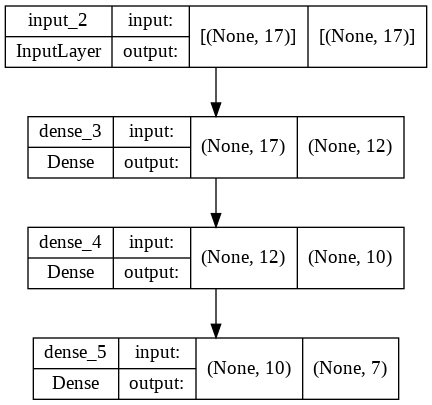

In [ ]:
#multiclass NN
#n = len(X.columns)
model2 = keras.models.Sequential([
    tf.keras.Input(shape=(len(X.columns),)),
    keras.layers.Dense(12, activation="relu"),
    keras.layers.Dense(10, activation="relu"),
    keras.layers.Dense(7, activation="softmax")
])
model2.summary()
keras.utils.plot_model(model2, "Bio-NN2.png", show_shapes=True)

In [ ]:
y_copy2 = y.copy()
d = dict(enumerate(set(y)))
d[6], d[5] = d[5], d[6]
y_copy2.replace(list(d.values()), list(d.keys()), inplace=True)

In [ ]:
y_copy2 = to_categorical(y_copy2)
#X_copy2 = X.copy()

Epoch 1/5
16519/16519 [==============================] - 47s 3ms/step - loss: 1.0194 - accuracy: 0.5274 - val_loss: 1.0206 - val_accuracy: 0.5281
Epoch 2/5
16519/16519 [==============================] - 47s 3ms/step - loss: 1.0147 - accuracy: 0.5286 - val_loss: 1.0159 - val_accuracy: 0.5272
Epoch 3/5
16519/16519 [==============================] - 52s 3ms/step - loss: 1.0108 - accuracy: 0.5304 - val_loss: 1.0116 - val_accuracy: 0.5298
Epoch 4/5
16519/16519 [==============================] - 41s 2ms/step - loss: 1.0074 - accuracy: 0.5323 - val_loss: 1.0080 - val_accuracy: 0.5290
Epoch 5/5
16519/16519 [==============================] - 48s 3ms/step - loss: 1.0040 - accuracy: 0.5336 - val_loss: 1.0043 - val_accuracy: 0.5323
2040/2040 - 2s - loss: 1.0011 - accuracy: 0.5340 - 2s/epoch - 1ms/step
accuracy: 53.40%
Epoch 1/5
16519/16519 [==============================] - 43s 3ms/step - loss: 1.0006 - accuracy: 0.5353 - val_loss: 1.0041 - val_accuracy: 0.5318
Epoch 2/5
16519/16519 [=============

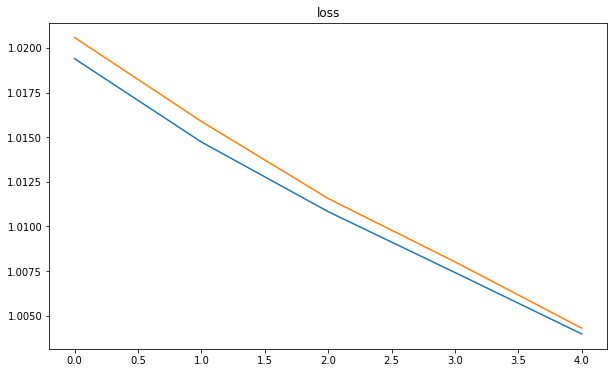

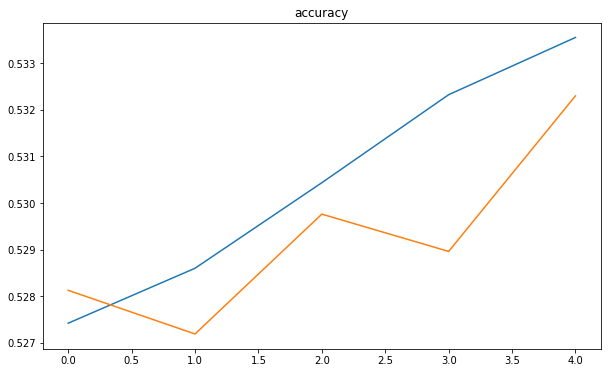

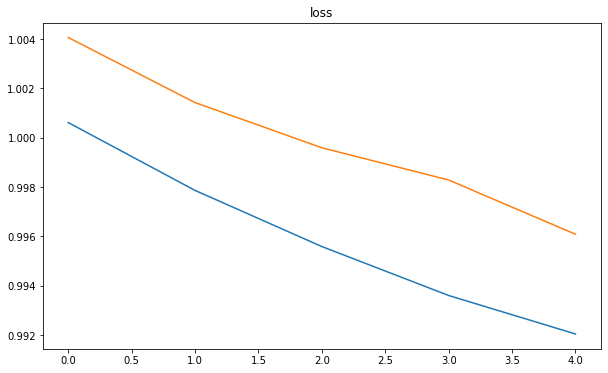

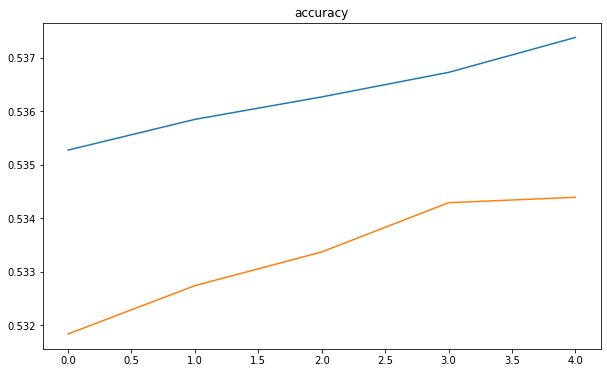

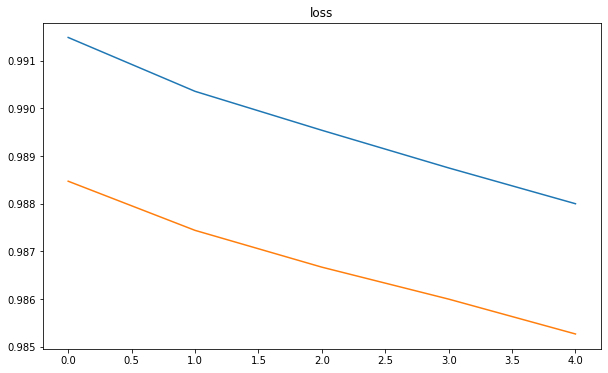

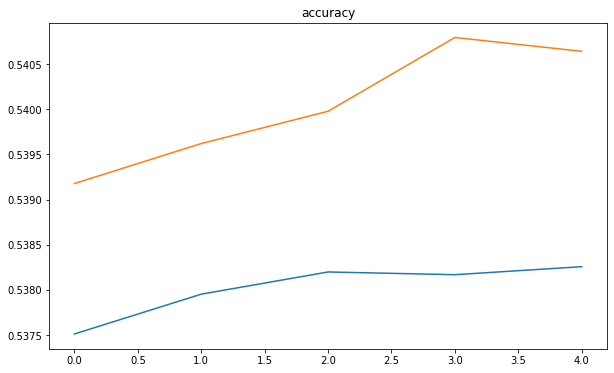

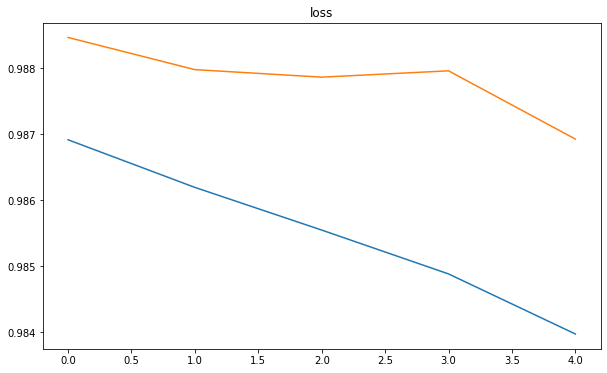

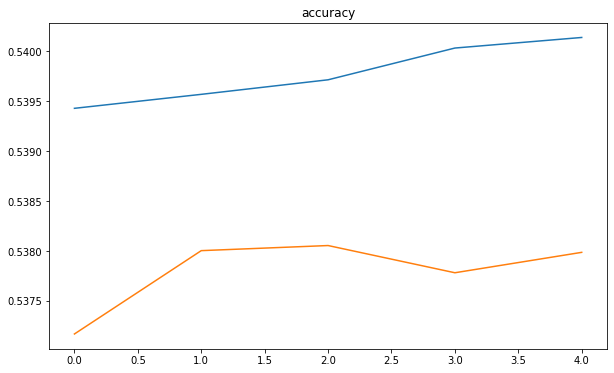

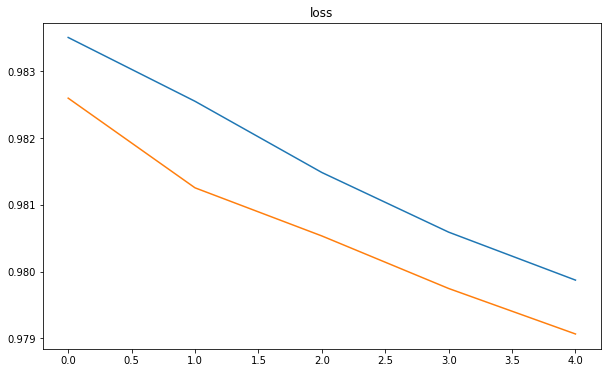

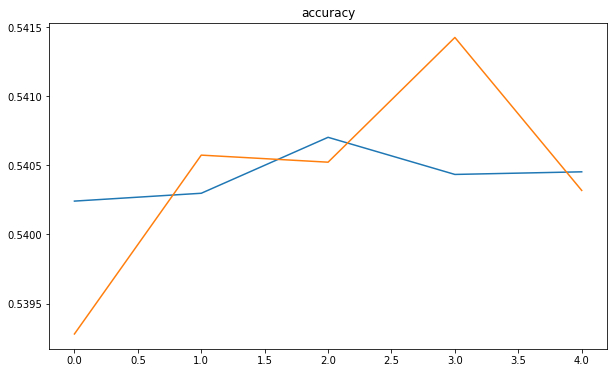

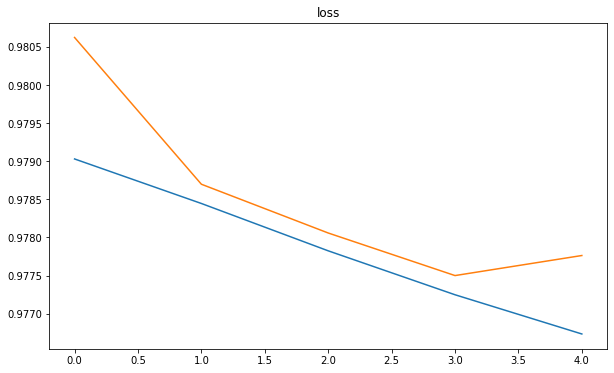

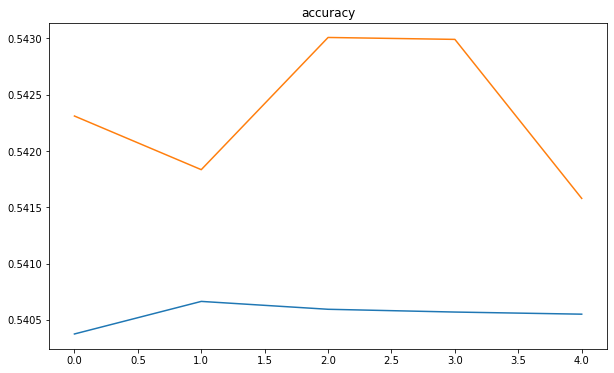

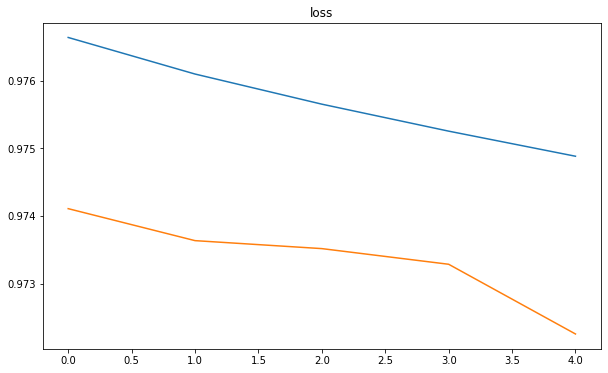

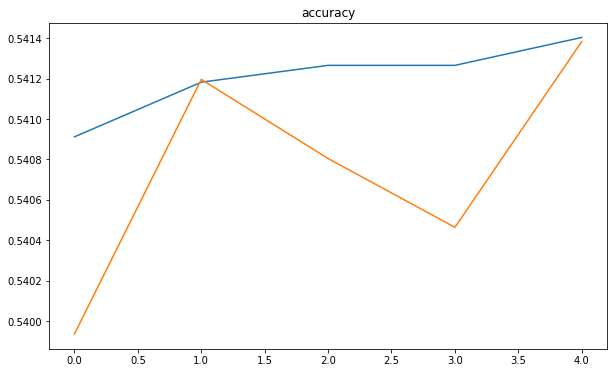

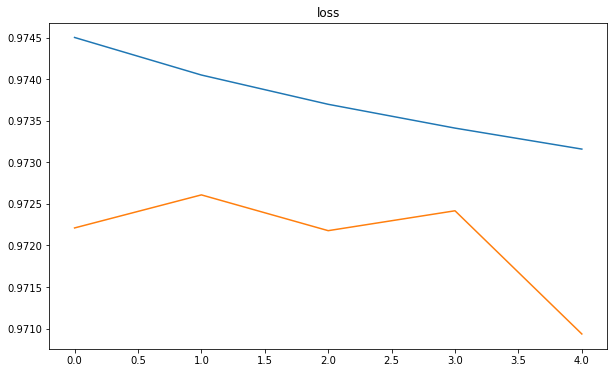

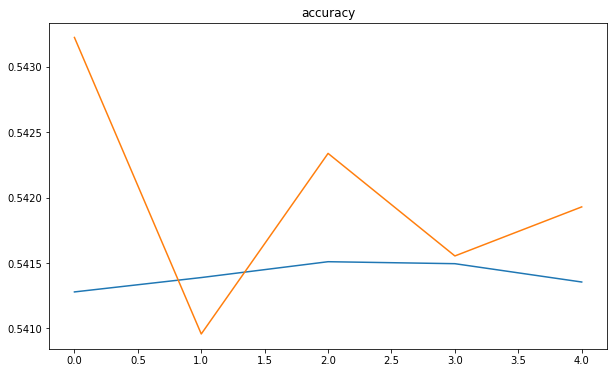

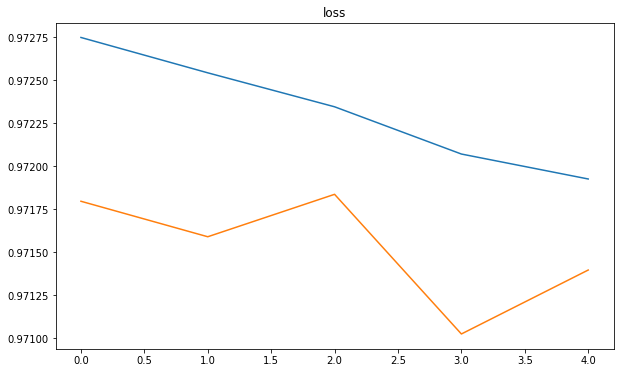

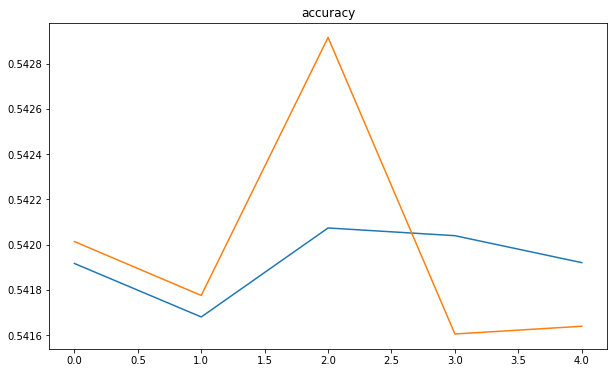

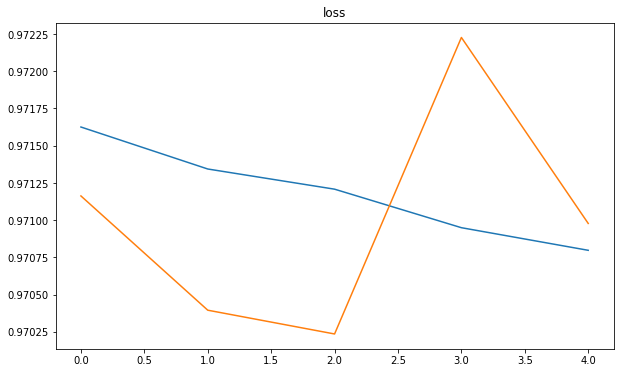

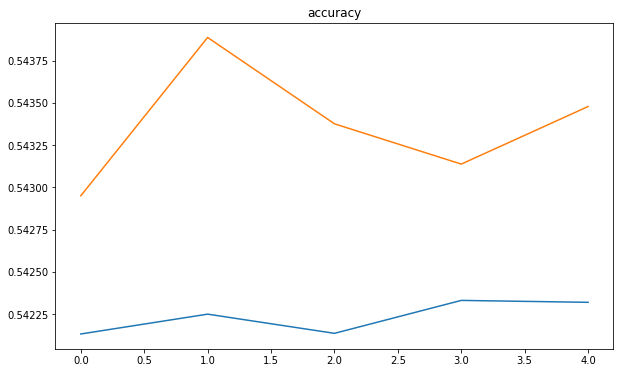

In [ ]:
# Split the dataset to define training and testing examples
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y_copy2, test_size=0.1, random_state=42,shuffle=True)

k = 10
kf = KFold(n_splits=k, random_state = None)
 
F1_MARK = []
 
for train_index , valid_index in kf.split(X_train_val):
    X_train , X_valid = X_train_val.iloc[train_index,:],X_train_val.iloc[valid_index,:]
    y_train , y_valid = y_train_val[train_index,:] , y_train_val[valid_index,:]
    #print(X_valid, y_valid)
    model2.compile(loss='categorical_crossentropy' ,optimizer=keras.optimizers.Adam(learning_rate=1e-4) , metrics=['accuracy'])
    history = model2.fit(X_train, y_train, epochs=5, validation_data=(X_valid, y_valid))
    
    pred_values = model2.predict(X_test).argmax(axis=1)
    pred_values = to_categorical(pred_values, num_classes=7)
     
    acc = f1_score(y_test, pred_values, average = 'macro')
    F1_MARK.append(acc)

    plot_loss(history)

    plot_accuracy(history)

    scores = model2.evaluate(X_test, y_test, verbose=2)
    print("%s: %.2f%%" % (model2.metrics_names[1], scores[1]*100))
     
avg_acc_score = sum(F1_MARK)/k

In [ ]:
y_copy2 = y.copy()
d = dict(enumerate(set(y)))
d[6], d[5] = d[5], d[6]
y_copy2.replace(list(d.values()), list(d.keys()), inplace=True)

In [ ]:
# Split the dataset to define training and testing examples
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y_copy2, test_size=0.1, random_state=42,shuffle=True)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.1, random_state=42,shuffle=True)
rf_grid_params = {
    'n_estimators': (5, 10, 20),
    'criterion': ['entropy'],
    'max_depth': (None, 3, 5, 10),
}
rf_clf = RandomForestClassifier(random_state= 42)
rf_v1 = GridSearchCV(rf_clf, rf_grid_params, n_jobs= -1, cv = 5)
rf_v1.fit(X_train, y_train)
y_train_pred = rf_v1.predict(X_train)
y_val_pred = rf_v1.predict(X_val)
print(f"Random Forest.\tTrain:{f1_score(y_train, y_train_pred,average = 'macro'):.4f}\tVal:{f1_score(y_val, y_val_pred,average = 'macro'):.4f}")

/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:705: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


Random Forest.	Train:0.2400	Val:0.2155


In [ ]:
# Split the dataset to define training and testing examples
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0)

In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn import linear_model
from sklearn.feature_selection import VarianceThreshold
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

%matplotlib inline

In [ ]:
name_of_the_model = './neural_network_model.pkl'

In [ ]:
clf = MLPClassifier()
y_pred = clf.fit(X_train, y_train).predict(X_test)
print("Number of mislabeled points out of a total %d points : %d; accuracy :" 
      % (X_test.shape[0], (y_test != y_pred).sum()), accuracy_score(y_test, y_pred, normalize=True))
print(classification_report(y_test, y_pred, zero_division=1))

Number of mislabeled points out of a total 65258 points : 28027; accuracy : 0.5705200894909437
              precision    recall  f1-score   support

       HBOND       0.66      0.73      0.69     29785
       IONIC       0.29      0.42      0.34       760
     Missing       0.52      0.58      0.55     19864
    PICATION       1.00      0.02      0.04        48
   PIPISTACK       0.38      0.61      0.47       931
      SSBOND       0.00      0.00      0.00        86
         VDW       0.42      0.21      0.28     13784

    accuracy                           0.57     65258
   macro avg       0.47      0.37      0.34     65258
weighted avg       0.56      0.57      0.55     65258



In [ ]:
import joblib

In [ ]:
#save to the disk the trained model
joblib.dump(clf, name_of_the_model)

['./neural_network_model.pkl']

# Model: SVM

In [ ]:
from sklearn import svm
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings("ignore")

In [ ]:
machine= svm.LinearSVC(random_state= 42)
best_machine= svm.LinearSVC(random_state= 42)
#svc_grid_params = {'C': (0.1, 0.5, 1., 5, 10)}

In [ ]:
#X_train_val, X_test, y_train_val, y_test = train_test_split(X, y_ss, test_size=0.1, random_state=42,shuffle=True)

y_train_ = y_vdw

k = 10
kf = KFold(n_splits=k, random_state = None)

# data preprocessing 
scaler = preprocessing.StandardScaler()
 
F1_MARK = []
k_=0
 
for train_index , valid_index in kf.split(X):
    X_train , X_valid = X.iloc[train_index,:], X.iloc[valid_index,:]
    y_train , y_valid = y_train_.iloc[train_index] , y_train_.iloc[valid_index]
    k_+=1
    
    scaler.fit(X_train)
    x_train = scaler.transform(X_train)
    x_valid = scaler.transform(X_valid)
    #x_test = scaler.transform(X_test)

    #best_machine = GridSearchCV(machine, svc_grid_params, n_jobs= -1)
    best_machine.fit(x_train, y_train)

    y_valid_pred = best_machine.predict(x_valid)
    #pred_values = best_machine.predict(x_test)
    #pred_values = round(pred_values)
     
    acc_v = best_machine.score(x_valid, y_valid)
    #acc_t = best_machine.score(x_test, y_test)

    #plot_loss(history)

    #plot_accuracy(history)

    f1_scores_v = f1_score(y_valid, y_valid_pred, average='macro')
    #f1_scores_t = f1_score(y_test, pred_values, average='macro')
    F1_MARK.append(f1_scores_v)
    print(f'Split number {k_}')
    print(f'Accuracy\tValid:{acc_v:.4f}\nF1 score\tValid: {f1_scores_v:.4f}')
     
avg_f1_score = sum(F1_MARK)/k
print(f'The average F1 score is {avg_f1_score}')

Split number 1
Accuracy	Valid:0.7835
F1 score	Valid: 0.4428
Split number 2
Accuracy	Valid:0.7950
F1 score	Valid: 0.4452
Split number 3
Accuracy	Valid:0.7916
F1 score	Valid: 0.4434
Split number 4
Accuracy	Valid:0.7921
F1 score	Valid: 0.4449
Split number 5
Accuracy	Valid:0.7792
F1 score	Valid: 0.4409
Split number 6
Accuracy	Valid:0.7858
F1 score	Valid: 0.4425
Split number 7
Accuracy	Valid:0.7961
F1 score	Valid: 0.4454
Split number 8
Accuracy	Valid:0.7875
F1 score	Valid: 0.4425
Split number 9
Accuracy	Valid:0.7881
F1 score	Valid: 0.4435
Split number 10
Accuracy	Valid:0.7846
F1 score	Valid: 0.4421
The average F1 score is 0.4433244497832486


In [ ]:

y_train_ = y_hb

k = 10
kf = KFold(n_splits=k, random_state = None)

# data preprocessing 
scaler = preprocessing.StandardScaler()
 
F1_MARK = []
k_=0
 
for train_index , valid_index in kf.split(X):
    X_train , X_valid = X.iloc[train_index,:], X.iloc[valid_index,:]
    y_train , y_valid = y_train_.iloc[train_index] , y_train_.iloc[valid_index]
    k_+=1
    
    scaler.fit(X_train)
    x_train = scaler.transform(X_train)
    x_valid = scaler.transform(X_valid)
    #x_test = scaler.transform(X_test)

    #best_machine = GridSearchCV(machine, svc_grid_params, n_jobs= -1)
    best_machine.fit(x_train, y_train)

    y_valid_pred = best_machine.predict(x_valid)
    #pred_values = best_machine.predict(x_test)
    #pred_values = round(pred_values)
     
    acc_v = best_machine.score(x_valid, y_valid)
    #acc_t = best_machine.score(x_test, y_test)

    #plot_loss(history)

    #plot_accuracy(history)

    f1_scores_v = f1_score(y_valid, y_valid_pred, average='macro')
    #f1_scores_t = f1_score(y_test, pred_values, average='macro')
    F1_MARK.append(f1_scores_v)
    print(f'Split number {k_}')
    print(f'Accuracy\tValid:{acc_v:.4f}\nF1 score\tValid: {f1_scores_v:.4f}')
     
avg_f1_score = sum(F1_MARK)/k
print(f'The average F1 score is {avg_f1_score}')

Split number 1
Accuracy	Valid:0.6663
F1 score	Valid: 0.6547
Split number 2
Accuracy	Valid:0.6806
F1 score	Valid: 0.6798
Split number 3
Accuracy	Valid:0.6694
F1 score	Valid: 0.6686
Split number 4
Accuracy	Valid:0.6660
F1 score	Valid: 0.6605
Split number 5
Accuracy	Valid:0.6654
F1 score	Valid: 0.6554
Split number 6
Accuracy	Valid:0.6714
F1 score	Valid: 0.6657
Split number 7
Accuracy	Valid:0.6793
F1 score	Valid: 0.6791
Split number 8
Accuracy	Valid:0.6698
F1 score	Valid: 0.6665
Split number 9
Accuracy	Valid:0.6639
F1 score	Valid: 0.6605
Split number 10
Accuracy	Valid:0.6761
F1 score	Valid: 0.6671
The average F1 score is 0.6657870758264101


In [ ]:
y_train_ = y_pip

k = 10
kf = KFold(n_splits=k, random_state = None)

# data preprocessing 
scaler = preprocessing.StandardScaler()
 
F1_MARK = []
k_=0
 
for train_index , valid_index in kf.split(X):
    X_train , X_valid = X.iloc[train_index,:], X.iloc[valid_index,:]
    y_train , y_valid = y_train_.iloc[train_index] , y_train_.iloc[valid_index]
    k_+=1
    
    scaler.fit(X_train)
    x_train = scaler.transform(X_train)
    x_valid = scaler.transform(X_valid)
    #x_test = scaler.transform(X_test)

    #best_machine = GridSearchCV(machine, svc_grid_params, n_jobs= -1)
    best_machine.fit(x_train, y_train)

    y_valid_pred = best_machine.predict(x_valid)
    #pred_values = best_machine.predict(x_test)
    #pred_values = round(pred_values)
     
    acc_v = best_machine.score(x_valid, y_valid)
    #acc_t = best_machine.score(x_test, y_test)

    #plot_loss(history)

    #plot_accuracy(history)

    f1_scores_v = f1_score(y_valid, y_valid_pred, average='macro')
    #f1_scores_t = f1_score(y_test, pred_values, average='macro')
    F1_MARK.append(f1_scores_v)
    print(f'Split number {k_}')
    print(f'Accuracy\tValid:{acc_v:.4f}\nF1 score\tValid: {f1_scores_v:.4f}')
     
avg_f1_score = sum(F1_MARK)/k
print(f'The average F1 score is {avg_f1_score}')

Split number 1
Accuracy	Valid:0.9836
F1 score	Valid: 0.4959
Split number 2
Accuracy	Valid:0.9866
F1 score	Valid: 0.4966
Split number 3
Accuracy	Valid:0.9867
F1 score	Valid: 0.4966
Split number 4
Accuracy	Valid:0.9871
F1 score	Valid: 0.4968
Split number 5
Accuracy	Valid:0.9851
F1 score	Valid: 0.4962
Split number 6
Accuracy	Valid:0.9853
F1 score	Valid: 0.4963
Split number 7
Accuracy	Valid:0.9874
F1 score	Valid: 0.4968
Split number 8
Accuracy	Valid:0.9860
F1 score	Valid: 0.4965
Split number 9
Accuracy	Valid:0.9855
F1 score	Valid: 0.4964
Split number 10
Accuracy	Valid:0.9855
F1 score	Valid: 0.4963
The average F1 score is 0.4964433315429602


In [ ]:
y_train_ = y_io

k = 10
kf = KFold(n_splits=k, random_state = None)

# data preprocessing 
scaler = preprocessing.StandardScaler()
 
F1_MARK = []
k_=0
 
for train_index , valid_index in kf.split(X):
    X_train , X_valid = X.iloc[train_index,:], X.iloc[valid_index,:]
    y_train , y_valid = y_train_.iloc[train_index] , y_train_.iloc[valid_index]
    k_+=1
    
    scaler.fit(X_train)
    x_train = scaler.transform(X_train)
    x_valid = scaler.transform(X_valid)
    #x_test = scaler.transform(X_test)

    #best_machine = GridSearchCV(machine, svc_grid_params, n_jobs= -1)
    best_machine.fit(x_train, y_train)

    y_valid_pred = best_machine.predict(x_valid)
    #pred_values = best_machine.predict(x_test)
    #pred_values = round(pred_values)
     
    acc_v = best_machine.score(x_valid, y_valid)
    #acc_t = best_machine.score(x_test, y_test)

    #plot_loss(history)

    #plot_accuracy(history)

    f1_scores_v = f1_score(y_valid, y_valid_pred, average='macro')
    #f1_scores_t = f1_score(y_test, pred_values, average='macro')
    F1_MARK.append(f1_scores_v)
    print(f'Split number {k_}')
    print(f'Accuracy\tValid:{acc_v:.4f}\nF1 score\tValid: {f1_scores_v:.4f}')
     
avg_f1_score = sum(F1_MARK)/k
print(f'The average F1 score is {avg_f1_score}')

Split number 1
Accuracy	Valid:0.9888
F1 score	Valid: 0.4972
Split number 2
Accuracy	Valid:0.9867
F1 score	Valid: 0.4967
Split number 3
Accuracy	Valid:0.9860
F1 score	Valid: 0.4965
Split number 4
Accuracy	Valid:0.9884
F1 score	Valid: 0.4971
Split number 5
Accuracy	Valid:0.9884
F1 score	Valid: 0.4971
Split number 6
Accuracy	Valid:0.9886
F1 score	Valid: 0.4971
Split number 7
Accuracy	Valid:0.9865
F1 score	Valid: 0.4966
Split number 8
Accuracy	Valid:0.9875
F1 score	Valid: 0.4969
Split number 9
Accuracy	Valid:0.9884
F1 score	Valid: 0.4971
Split number 10
Accuracy	Valid:0.9881
F1 score	Valid: 0.4970
The average F1 score is 0.49691542439872005


In [ ]:
y_train_ = y_ss

k = 10
kf = KFold(n_splits=k, random_state = None)

# data preprocessing 
scaler = preprocessing.StandardScaler()
 
F1_MARK = []
k_=0
 
for train_index , valid_index in kf.split(X):
    X_train , X_valid = X.iloc[train_index,:], X.iloc[valid_index,:]
    y_train , y_valid = y_train_.iloc[train_index] , y_train_.iloc[valid_index]
    k_+=1
    
    scaler.fit(X_train)
    x_train = scaler.transform(X_train)
    x_valid = scaler.transform(X_valid)
    #x_test = scaler.transform(X_test)

    #best_machine = GridSearchCV(machine, svc_grid_params, n_jobs= -1)
    best_machine.fit(x_train, y_train)

    y_valid_pred = best_machine.predict(x_valid)
    #pred_values = best_machine.predict(x_test)
    #pred_values = round(pred_values)
     
    acc_v = best_machine.score(x_valid, y_valid)
    #acc_t = best_machine.score(x_test, y_test)

    #plot_loss(history)

    #plot_accuracy(history)

    f1_scores_v = f1_score(y_valid, y_valid_pred, average='macro')
    #f1_scores_t = f1_score(y_test, pred_values, average='macro')
    F1_MARK.append(f1_scores_v)
    print(f'Split number {k_}')
    print(f'Accuracy\tValid:{acc_v:.4f}\nF1 score\tValid: {f1_scores_v:.4f}')
     
avg_f1_score = sum(F1_MARK)/k
print(f'The average F1 score is {avg_f1_score}')

Split number 1
Accuracy	Valid:0.9991
F1 score	Valid: 0.4998
Split number 2
Accuracy	Valid:0.9985
F1 score	Valid: 0.4996
Split number 3
Accuracy	Valid:0.9988
F1 score	Valid: 0.4997
Split number 4
Accuracy	Valid:0.9992
F1 score	Valid: 0.4998
Split number 5
Accuracy	Valid:0.9989
F1 score	Valid: 0.4997
Split number 6
Accuracy	Valid:0.9979
F1 score	Valid: 0.4995
Split number 7
Accuracy	Valid:0.9984
F1 score	Valid: 0.4996
Split number 8
Accuracy	Valid:0.9992
F1 score	Valid: 0.4998
Split number 9
Accuracy	Valid:0.9989
F1 score	Valid: 0.4997
Split number 10
Accuracy	Valid:0.9991
F1 score	Valid: 0.4998
The average F1 score is 0.4997006007336237


In [ ]:
y_train_ = y_pic

k = 10
kf = KFold(n_splits=k, random_state = None)

# data preprocessing 
scaler = preprocessing.StandardScaler()
 
F1_MARK = []
k_=0
 
for train_index , valid_index in kf.split(X):
    X_train , X_valid = X.iloc[train_index,:], X.iloc[valid_index,:]
    y_train , y_valid = y_train_.iloc[train_index] , y_train_.iloc[valid_index]
    k_+=1
    
    scaler.fit(X_train)
    x_train = scaler.transform(X_train)
    x_valid = scaler.transform(X_valid)
    #x_test = scaler.transform(X_test)

    #best_machine = GridSearchCV(machine, svc_grid_params, n_jobs= -1)
    best_machine.fit(x_train, y_train)

    y_valid_pred = best_machine.predict(x_valid)
    #pred_values = best_machine.predict(x_test)
    #pred_values = round(pred_values)
     
    acc_v = best_machine.score(x_valid, y_valid)
    #acc_t = best_machine.score(x_test, y_test)

    #plot_loss(history)

    #plot_accuracy(history)

    f1_scores_v = f1_score(y_valid, y_valid_pred, average='macro')
    #f1_scores_t = f1_score(y_test, pred_values, average='macro')
    F1_MARK.append(f1_scores_v)
    print(f'Split number {k_}')
    print(f'Accuracy\tValid:{acc_v:.4f}\nF1 score\tValid: {f1_scores_v:.4f}')
     
avg_f1_score = sum(F1_MARK)/k
print(f'The average F1 score is {avg_f1_score}')

Split number 1
Accuracy	Valid:0.9990
F1 score	Valid: 0.4997
Split number 2
Accuracy	Valid:0.9990
F1 score	Valid: 0.4998
Split number 3
Accuracy	Valid:0.9994
F1 score	Valid: 0.4998
Split number 4
Accuracy	Valid:0.9992
F1 score	Valid: 0.4998
Split number 5
Accuracy	Valid:0.9991
F1 score	Valid: 0.4998
Split number 6
Accuracy	Valid:0.9990
F1 score	Valid: 0.4998
Split number 7
Accuracy	Valid:0.9992
F1 score	Valid: 0.4998
Split number 8
Accuracy	Valid:0.9992
F1 score	Valid: 0.4998
Split number 9
Accuracy	Valid:0.9992
F1 score	Valid: 0.4998
Split number 10
Accuracy	Valid:0.9994
F1 score	Valid: 0.4998
The average F1 score is 0.49979112199077314


In [ ]:
y_train_ = y_miss

k = 10
kf = KFold(n_splits=k, random_state = None)

# data preprocessing 
scaler = preprocessing.StandardScaler()
 
F1_MARK = []
k_=0
 
for train_index , valid_index in kf.split(X):
    X_train , X_valid = X.iloc[train_index,:], X.iloc[valid_index,:]
    y_train , y_valid = y_train_.iloc[train_index] , y_train_.iloc[valid_index]
    k_+=1
    
    scaler.fit(X_train)
    x_train = scaler.transform(X_train)
    x_valid = scaler.transform(X_valid)
    #x_test = scaler.transform(X_test)

    #best_machine = GridSearchCV(machine, svc_grid_params, n_jobs= -1)
    best_machine.fit(x_train, y_train)

    y_valid_pred = best_machine.predict(x_valid)
    #pred_values = best_machine.predict(x_test)
    #pred_values = round(pred_values)
     
    acc_v = best_machine.score(x_valid, y_valid)
    #acc_t = best_machine.score(x_test, y_test)

    #plot_loss(history)

    #plot_accuracy(history)

    f1_scores_v = f1_score(y_valid, y_valid_pred, average='macro')
    #f1_scores_t = f1_score(y_test, pred_values, average='macro')
    F1_MARK.append(f1_scores_v)
    print(f'Split number {k_}')
    print(f'Accuracy\tValid:{acc_v:.4f}\nF1 score\tValid: {f1_scores_v:.4f}')
     
avg_f1_score = sum(F1_MARK)/k
print(f'The average F1 score is {avg_f1_score}')

Split number 1
Accuracy	Valid:0.6628
F1 score	Valid: 0.4993
Split number 2
Accuracy	Valid:0.7349
F1 score	Valid: 0.5519
Split number 3
Accuracy	Valid:0.7336
F1 score	Valid: 0.5422
Split number 4
Accuracy	Valid:0.6810
F1 score	Valid: 0.5135
Split number 5
Accuracy	Valid:0.6685
F1 score	Valid: 0.5013
Split number 6
Accuracy	Valid:0.6987
F1 score	Valid: 0.5333
Split number 7
Accuracy	Valid:0.7476
F1 score	Valid: 0.5496
Split number 8
Accuracy	Valid:0.7061
F1 score	Valid: 0.5248
Split number 9
Accuracy	Valid:0.6971
F1 score	Valid: 0.5159
Split number 10
Accuracy	Valid:0.6720
F1 score	Valid: 0.5038
The average F1 score is 0.5235454505471242


#Final Model

In [ ]:
def final_predictor(structure):
  

In [ ]:
#tab_file#
path_file = "./my_pdb.tsv"

df = pd.read_csv(path_file, sep ="\t")

X_ = df[['s_rsa', 's_down', 's_phi', 's_psi', 's_a1', 's_a2', 's_a3', 's_a4', 
        't_rsa', 't_up', 't_down', 't_phi', 't_psi', 't_a1', 't_a2', 't_a3', 't_a4']]




# save models


In [ ]:
#save to the disk the trained model
name_of_the_model = './random_forest_hb.pkl'
joblib.dump(rf_hb, name_of_the_model)

NameError: ignored

In [24]:
#save to the disk the trained model
name_of_the_model = './random_forest_io.pkl'
joblib.dump(rf_io, name_of_the_model)

['./random_forest_io.pkl']

In [ ]:
#save to the disk the trained model
name_of_the_model = './random_forest_miss.pkl'
joblib.dump(rf_miss, name_of_the_model)

NameError: ignored

In [28]:
#save to the disk the trained model
name_of_the_model = './random_forest_pip.pkl'
joblib.dump(rf_pip, name_of_the_model)

['./random_forest_pip.pkl']

In [32]:
#save to the disk the trained model
name_of_the_model = './random_forest_pic.pkl'
joblib.dump(rf_pic, name_of_the_model)

['./random_forest_pic.pkl']

In [36]:
#save to the disk the trained model
name_of_the_model = './random_forest_ss.pkl'
joblib.dump(rf_ss, name_of_the_model)

['./random_forest_ss.pkl']

In [47]:
name_of_the_model = './random_forest_vdw.pkl'
joblib.dump(rf_vdw, name_of_the_model)

['./random_forest_vdw.pkl']